In [10]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [11]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=640):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "Images", id_name)
        mask_path = os.path.join(self.path, "Mask", id_name)
        
        ## Reading Image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.image_size, self.image_size))

        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if (index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        # print("files_batch: ", files_batch)
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [12]:
image_size = 640
train_path = "dataset_copy/train/"
valid_path = "dataset_copy/valid/"
epochs = 10
batch_size = 1

## Training Ids
train_ids = os.listdir(train_path + "Images")
valid_ids = os.listdir(valid_path + "Images")
print(len(train_ids), train_ids)
print(len(valid_ids), valid_ids)


20 ['11_jpg.rf.2e71343ba8845ca7db0b208ae1a6b064.jpg', '15_jpg.rf.f3e94e1d46d5f7819cc7452c26f0c39d.jpg', '16_jpg.rf.7f8c8b9aa40f838e8fcb2019e8fdf1c5.jpg', '17_jpg.rf.34b127ffb1f6fe3b89a59a9e679ccbf8.jpg', '28_jpg.rf.416970d7b8f6f165899f2cb9fbdeb255.jpg', '2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg', '31_jpg.rf.04c05c4fcec9d25ce5a3850132918cf3.jpg', '32_jpg.rf.4a2cfaf76af2ac413b59ed5e38b74234.jpg', '33_jpg.rf.14971cd36877b3bbe67aacd82a54a056.jpg', '34_jpg.rf.904071a9f76c2fbfb0300c61acd11c77.jpg', '42_jpg.rf.afc8f55bf7dc8ccb93ce07f8d1fbd21e.jpg', '47_jpg.rf.9972810faa9742aa7ac615a7cc4879de.jpg', '48_jpg.rf.5c918ab525f1d5ad778d8e4b10ac3f98.jpg', '4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg', '51_jpg.rf.bae4e9311235120de3eb582a20906575.jpg', '52_jpg.rf.6923b3fdcec7b389ae93a0c066525cb8.jpg', '55_jpg.rf.43720c46d4070d62857005129198ba2f.jpg', '56_jpg.rf.1889c38f07f615764970a7ba6ef58734.jpg', '60_jpg.rf.353d60a2b7e220bcbb9799672932b0fd.jpg', '8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg']

In [13]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)
x, y = gen.__getitem__(1)
print(x.shape, y.shape)

(4, 640, 640, 1) (4, 640, 640, 1)
(4, 640, 640, 1) (4, 640, 640, 1)


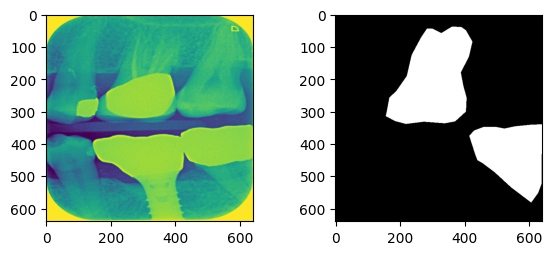

In [14]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [15]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [16]:
def UNet():
    f = [80, 160, 320, 640, 1280]
    inputs = keras.layers.Input((image_size, image_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #
    c2, p2 = down_block(p1, f[1]) #
    c3, p3 = down_block(p2, f[2]) #
    c4, p4 = down_block(p3, f[3]) #
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #
    u2 = up_block(u1, c3, f[2]) #
    u3 = up_block(u2, c2, f[1]) #
    u4 = up_block(u3, c1, f[0]) #
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [17]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary(line_length=100)

Model: "model_1"
____________________________________________________________________________________________________
 Layer (type)                 Output Shape                  Param #   Connected to                  
 input_2 (InputLayer)         [(None, 640, 640, 1)]         0         []                            
                                                                                                    
 conv2d_19 (Conv2D)           (None, 640, 640, 80)          800       ['input_2[0][0]']             
                                                                                                    
 conv2d_20 (Conv2D)           (None, 640, 640, 80)          57680     ['conv2d_19[0][0]']           
                                                                                                    
 max_pooling2d_4 (MaxPooling  (None, 320, 320, 80)          0         ['conv2d_20[0][0]']           
 2D)                                                                      

## Training the model

In [18]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, valid_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print(train_steps, valid_steps)

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)


5 9


C:\Users\Mered\AppData\Local\Temp\ipykernel_14396\59060332.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/10
5/5 [==============================] - 425s 91s/step - loss: 144.8438 - acc: 0.6912 - val_loss: 0.6600 - val_acc: 0.8208
Epoch 2/10


## Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
test_path = "dataset/test/"
test_ids = os.listdir(test_path + "/Images")
test_gen = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size)
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")